# Pneumonia Classification Detection using TensorFlow

The code below will prepare the **ChestXRay2017** dataset for your assignment. It is a medical imaging dataset consisting of chest X-ray images used for binary classification between *normal* lungs and those affected by *pneumonia*. It is distributed in TFRecord format and hosted on a public Google Cloud Storage (GCS) bucket. To use the dataset locally, the TFRecord files `images.tfrec` and `paths.tfrec` are first downloaded using `gsutil` into a designated folder (e.g., `./chestxray`). The `images.tfrec` file contains the raw JPEG-encoded image data, while `paths.tfrec` provides the relative file paths, which include class information (`NORMAL` or `PNEUMONIA`). Each image-label pair is extracted by decoding the image and inferring the label based on the presence of "normal" in the corresponding path. Once decoded, the dataset is shuffled and split into three parts: 60% for training, 10% for validation, and 30% for testing.

Let's start with the imports and the dataset preparation code. The code below will download the dataset, extract the images and labels, and split

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def set_seeds(seed=0):
  os.environ["PYTHONHASHSEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [3]:
set_seeds()

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32
TFRECORD_DIR = "./chestxray"
IMAGE_TFRECORD = os.path.join(TFRECORD_DIR, "images.tfrec")
PATH_TFRECORD = os.path.join(TFRECORD_DIR, "paths.tfrec")

In [5]:
os.makedirs(TFRECORD_DIR, exist_ok=True)

if not os.path.exists(IMAGE_TFRECORD) or not os.path.exists(PATH_TFRECORD):
    !mkdir -p chestxray
    !gsutil cp gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec chestxray/
    !gsutil cp gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec chestxray/

Copying gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  1.1 GiB/  1.1 GiB]   22.5 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      
Copying gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec...
- [1 files][270.6 KiB/270.6 KiB]                                                
Operation completed over 1 objects/270.6 KiB.                                    


In [6]:
def prepare_dataset(image_file, path_file, batch_size=32):
    image_ds = tf.data.TFRecordDataset(image_file)
    path_ds = tf.data.TFRecordDataset(path_file)
    ds = tf.data.Dataset.zip((image_ds, path_ds))

    def decode(image_bytes, path_bytes):
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        label = tf.where(tf.strings.regex_full_match(tf.strings.lower(path_bytes), ".*normal.*"), 0, 1)
        return image, label

    total = sum(1 for _ in tf.data.TFRecordDataset(path_file))

    ds = ds.map(decode, num_parallel_calls=tf.data.AUTOTUNE).cache()
    ds = ds.apply(tf.data.experimental.assert_cardinality(total)).shuffle(total, seed=123)

    train_size = int(total * 0.6)
    val_size = int(total * 0.1)

    train = ds.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val = ds.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = ds.skip(train_size + val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, val, test, total

In [7]:
train_ds, val_ds, test_ds, total_count = prepare_dataset(IMAGE_TFRECORD, PATH_TFRECORD, BATCH_SIZE)
print("Dataset ready. Total samples:", total_count)

Dataset ready. Total samples: 5232


**Your code to complete the given tasks:**

**Task 1: Display a grid of several images (e.g., 4 x 4 images) from the training set,
with each image annotated by its corresponding label**

Here's my code for plotting a grid of images with their labels. It's just a for loop iterating through the training dataset and then plotting the images in a grid.

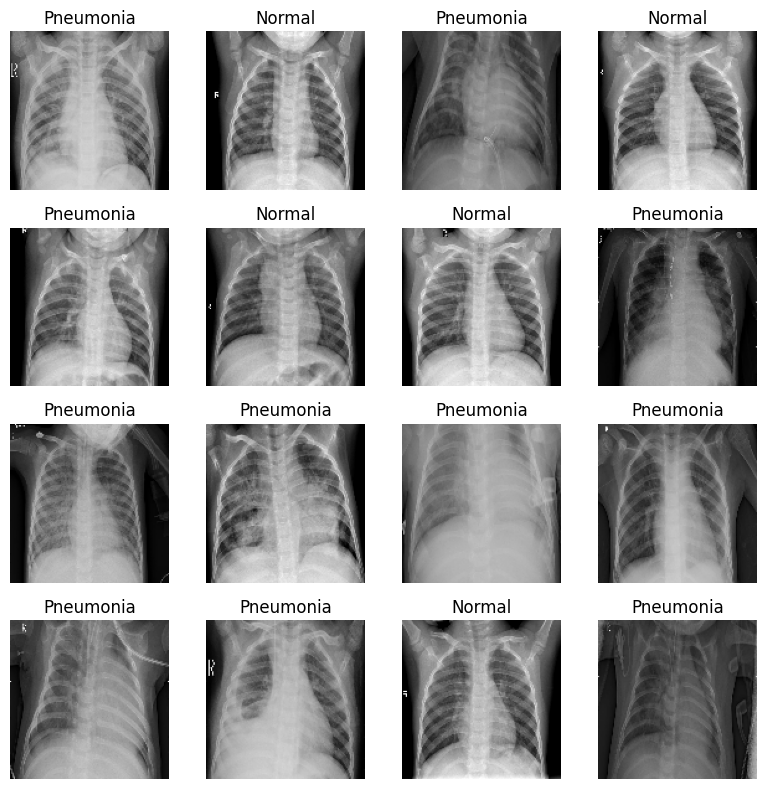

In [8]:
#map the labels numbers to class namess
class_names = ["Normal", "Pneumonia"]

#get a batch from the dataset
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

#plot a 4x4 grid (16 images)
n_rows, n_cols = 4, 4
fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

**Task 2: Choose a pretrained model from Keras, modify it for transfer learning, and
train it using the training and validation sets.**

Below is the code for using a pre-trained model. I used Xception for this project. After that I trained the model using the training and validation sets.

In [9]:
#Load Xception base model
base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
#freeze layers
base_model.trainable = False

#Build the full architecture
model = keras.Sequential([
    keras.layers.Rescaling(1./255),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

#compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [10]:
#train the model
initial_epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8837 - loss: 0.2663 - val_accuracy: 0.9484 - val_loss: 0.1369
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9259 - loss: 0.1852 - val_accuracy: 0.9293 - val_loss: 0.1652
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9321 - loss: 0.1793 - val_accuracy: 0.9618 - val_loss: 0.1107
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9470 - loss: 0.1420 - val_accuracy: 0.9541 - val_loss: 0.1214
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9511 - loss: 0.1341 - val_accuracy: 0.9541 - val_loss: 0.0977
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9480 - loss: 0.1175 - val_accuracy: 0.9656 - val_loss: 0.1154
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9560 - loss: 0.1175 - val_accuracy: 0.9312 - val_loss: 0.1716
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9494 - loss: 0.1373 - val_accuracy: 0.9694 -

**Task 3: Plot the training and valdation loss curves together on a single graph.**
The code below will plot both the training and validation accuracy and loss curves on a single graph.

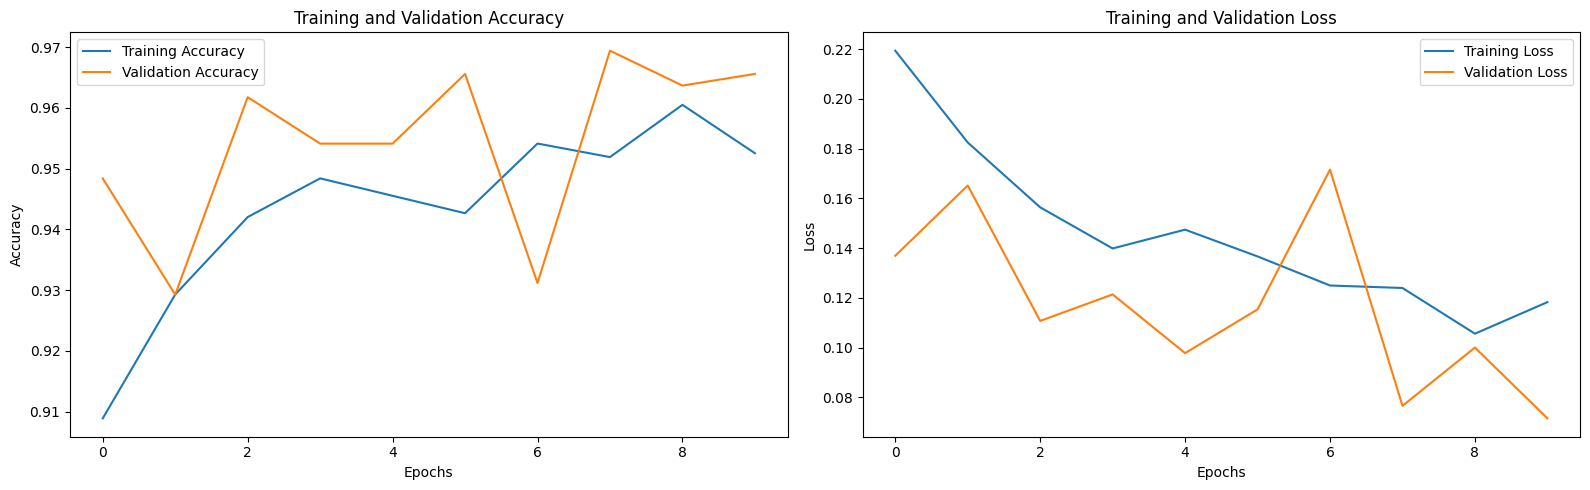

In [11]:
#Plotting the training and validation process

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))


#create the figure
plt.figure(figsize=(16, 5))

#plot the accuracy of the 5 epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plot the loss of the 5 epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Task 4: Evaluate the Model on the Test Set. Achieve a test accuracy of at least 96%**:

In this cell here, I evaluated the model and achieved a test accuracy of 96.9% on the test set.

In [12]:
#evaluating on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.3f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9649 - loss: 0.0976
Test accuracy: 0.969


**Task 5: Display a grid of several images (e.g 4x4) from the test set, each annotated with the true label, the predicted label, and the corresponding prediction probability**:

Next in this cell, I displayed a grid of images from the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


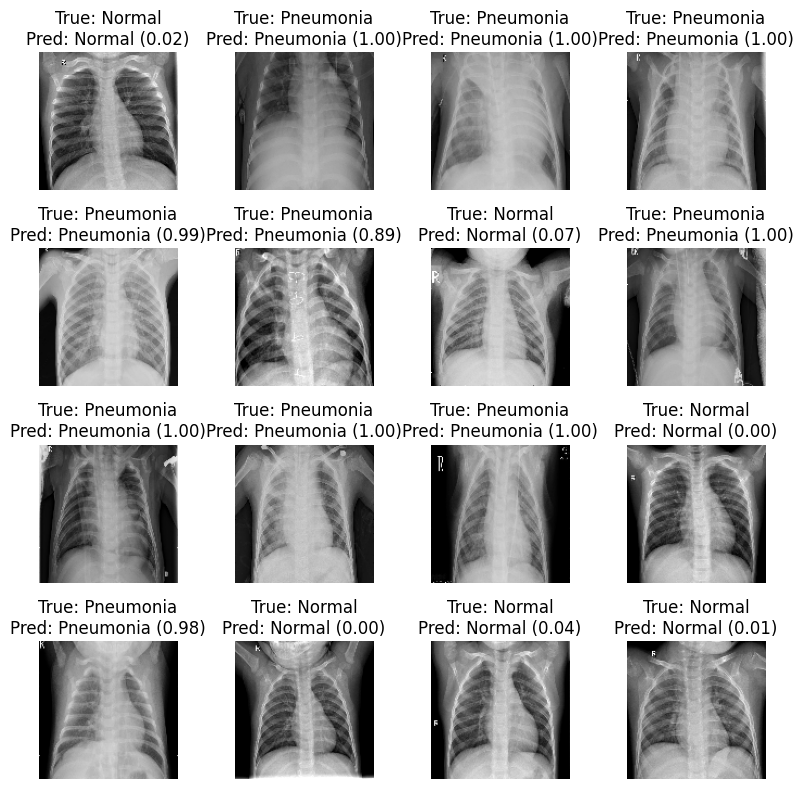

In [ ]:
#Create a  for loop tp plot the testing data
#get one batch of test data
for images, labels in test_ds.take(1):
  #this code is similiar to the code for plotting the training sets
  probs = model.predict(images)
  preds = (probs > 0.5).astype(int)

  plt.figure(figsize=(8, 8))
  for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].numpy().astype("uint8")
        true_label = 'Normal' if labels[i].numpy() == 0 else 'Pneumonia'
        pred_label = 'Normal' if preds[i][0] == 0 else 'Pneumonia'
        prob = probs[i][0]

        plt.imshow(img.astype("uint8"))
        plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})")
        plt.axis("off")
  plt.tight_layout()
  plt.show()
  break

**Task 6. Further improve your current model by techniques such as fine-tuning,
modifying the architecture, applying data augmentation, incorporating
learning rate scheduling, and/or using appropriate callbacks, etc., with the
goal of achieving a higher test accuracy than the previous version.**

In this cell, I used data augmentation and implemented a 2-stage fine tuning process. Further details are in the discussion below. This implementation achieved a test accuracy of 98.5%

In [ ]:
#part 2
#Here I'll fine tune the model:
#data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")

#Build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

#Compile and train (part1)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history1 = model.fit(train_ds, validation_data=val_ds, epochs=10)
#Unfreeze top layers (part2)
base_model.trainable = True
#Freeze first 100 layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#Re-compile with lower LR and fine-tune
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history2 = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.8364 - loss: 0.3775 - val_accuracy: 0.8891 - val_loss: 0.3798
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9503 - loss: 0.1329 - val_accuracy: 0.9426 - val_loss: 0.1365
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9655 - loss: 0.1065 - val_accuracy: 0.9713 - val_loss: 0.0885
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9583 - loss: 0.1048 - val_accuracy: 0.9713 - val_loss: 0.0783
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9663 - loss: 0.0984 - val_accuracy: 0.9637 - val_loss: 0.0814
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9619 - loss: 0.0927 - val_accuracy: 0.9675 - val_loss: 0.0750
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9750 - loss: 0.0728 - val_accuracy: 0.9484 - val_loss: 0.1420
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9781 - loss: 0.0726 - val_accu

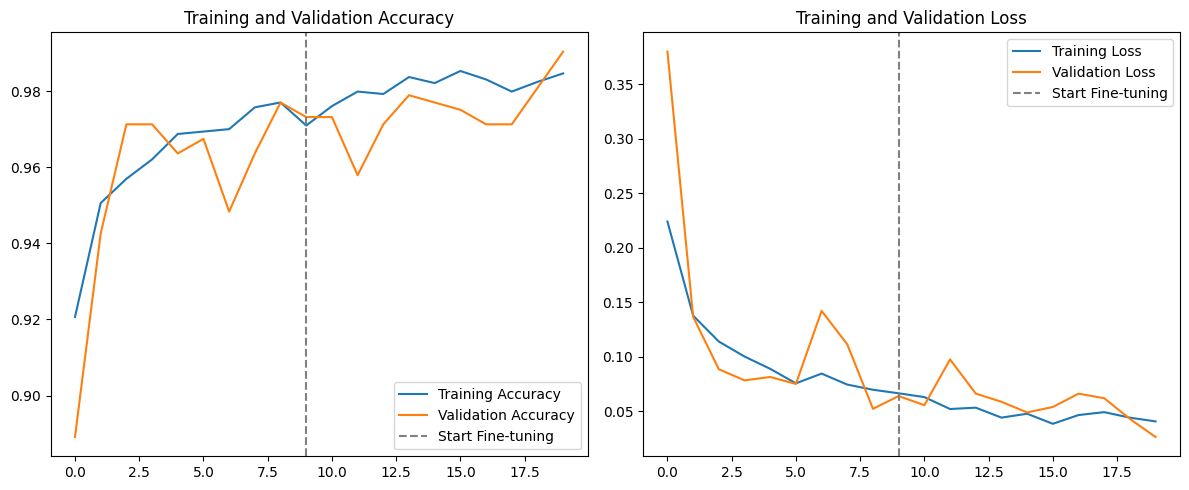

In [17]:
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history1.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(history1.history['loss']) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning: {test_acc:.3f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9904 - loss: 0.0288
Test accuracy after fine-tuning: 0.985


**Task 7: Include a discussion at the end of your notebook (about what you have learned, difficulties, what has worked and not worked, future directions, etc.)**.

**My Discussion:**

The project is done in google colab. It starts with setting up the the environment and downloading the dataset. The starter code has already done the pre-processing and data preparation + splitting too. All of the images are resized to 128x128 pixels as a standard input shapes.The ChestXRay2017 dataset is loaded and preprocessed, containing around 5,232 samples.

**First Model**

Next is the first model using the pre-trained Xception model. Xception (Extreme Inception) is a model based off of the inception-V3 model. It is a deep CNN architecture that uses a linear stack of depth-wise separable convolution layers. It separates the learning of channel-wise and space-wise features, which allows for more efficient learning. The model is trained using the Adam optimizer with a learning rate of 0.0001 and a batch size of 32, with around 10 epochs. GlobalAveragePooling2D() was used to reduce spatial dimensions of the feature maps. I added 2 dropout layers which helps with regalarization and prevents overfitting. The final layer is a dense layer with sigmoid activation function because it's a binary classification. The result was exceptionally good, with a test accuracy of 96.9% on the test set. Previously I didn't use any dropout layers, and the model was stuck at around 93% accuracy. So adding more reguralization was key to improving performance with the base model.

I then plotted the curves for both loss and accuracy for both training and validation sets. The curves show that the model is learning well, however during the 6th epoch, the validation accuracy started to spike downwards (maybe due to overfitting). But with dropout layers, the model was able to recover and continue to learn well after the 6th epoch. So adding dropout layers was a great choice. I plotted images from the testing set with their true labels, predicted labels, and prediction probabilities, and it had great accuracy.


**Second Model: Fine Tuned**

The second model is a fine-tuned version of the first model. I used the same base model, but this time I added data augmentation to the training set and also used 2-stage fine tuning approach for the Xception base model. 

Data augmentation can help expose the model to more variety. It can help the model learn to generalize better and reduce overfitting. I used a few augmentation techniques such as rotation, zoom, width and height shift, shear, and horizontal flip. Like how in the real world where a model might see a rotated image or an imaged that has been zoomed in or out.

This 2-stage method has a few benefits, such as it can leverage pre-trained representations by only fine-tuning a small portion of the model parameters. It balanced generality and task-specific learning. It also has the benefit  of allowing the model to learn the initial representation of a specific task. In the architecture I froze the entire Xception base initially (like in the first model). I then continued and unforze the top 100 layers of the Xception model, while keeping the rest frozen. Higher layers can learn task-specific features, while lower layers learn more general features. This resulted in a test accuracy of 98.5% on the test set, which is a significant improvement over the first model. I also plotted the loss and accuracy curves for both training and validation sets, with a graph that shows what I expected.

Previously, I tried using learning-rate scheduling, but it didn't work well. I tried adding callbacks such as EarlyStopping and ModelCheckpoint, but it didn't help much, my model was still stuck at 96% accuracy. This 2-stage fine tuning approach worked for me.

For Future directions, I would imagine that the base model should be changed to a more advanced model such as EfficientNet or ResNet. I would also try using a larger batch size and more epochs to see if that helps improve the performance of the model.

Sources: 
- http://dx.doi.org/10.1109/ITCA52113.2020.00063 (for Xception model)
- https://arxiv.org/abs/2207.10858 (for 2 step fine tuning)






